You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


# Load Experimental data

## select files and channels

In [3]:
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit2']
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
i = 0
rstate_list[i] = rstate_list[i][53-1,:]
cSTA = np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same')
cSTA = cSTA[int(len(cSTA)/2)+1:int(len(cSTA)/2-1/dt)+1:-1]

# Fake Spike - Berry Gain Control

## parameters for LC model and Spike Generator

In [4]:
cSTA = -cSTA

In [16]:
#Gain control function
def gain_func(volt):
    v = volt.copy()
    try: v[v < 0] = 0
    except: 
        if v<0: v=0
    return 1/(1+v**4)
tau = 0.5#sec
B = 200
decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
decay = decay

In [22]:
stimulus = np.repeat(np.array([0.5,0.625,0.375,0.75,0.25,0.9,0.1]),100)*2
sstm = np.zeros_like(stimulus)
for i in range(len(cSTA)-1):
    for ii in range(i+1):
        sstm[i] += stimulus[ii]*cSTA[i-ii]*dt
sx = np.convolve(stimulus,cSTA,'valid')*dt
sstm[len(cSTA)-1:] = sx.copy()

output = np.zeros_like(sstm)
gain = np.zeros_like(sstm)
hv = np.zeros_like(sstm)
for i in np.arange(1,len(sstm)):
    hv[i] = np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt)
    gain[i] = gain_func(hv[i])
    output[i] = gain[i]*sstm[i]

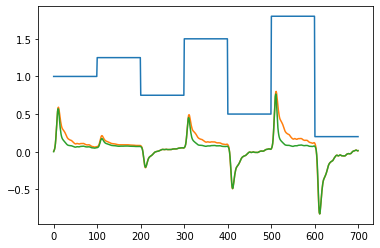

In [23]:
plt.plot(stimulus)
plt.plot(sstm*10)
plt.plot(output*10)
# plt.plot(gain)

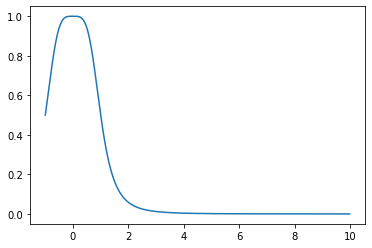

In [18]:
volt = np.arange(-1,10,0.01)
plt.plot(volt,gain_func(volt))

In [136]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for j in range(len(x_list)):
    stimulus = x_list[j]*3+10
    sstm = np.zeros_like(stimulus)
    for i in range(len(cSTA)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*cSTA[i-ii]*dt
    sx = np.convolve(stimulus,cSTA,'valid')*dt
    sstm[len(cSTA)-1:] = sx.copy()
    
    output = np.zeros_like(sstm)
    gain = np.zeros_like(sstm)
    hv = np.zeros_like(sstm)
    for i in np.arange(1,len(sstm)):
        hv[i] = np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt)
        gain[i] = gain_func(hv[i])
        output[i] = gain[i]*sstm[i]
#     output[output<0] = 0
    


    r = NL(output-np.mean(output), 0)
    ratio = sum(r)/T_list[j][-1]/2
    FakeSpike_list[j] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[j], _ = np.histogram(FakeSpike_list[j], np.append(0,T_list[j]))

(14000, 16000)

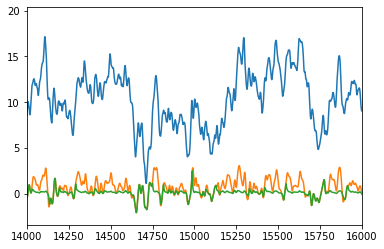

In [137]:
plt.plot(stimulus)
plt.plot(sstm*10)
plt.plot(output*10)
plt.xlim([14000,16000])

## Plot MI